In [1]:
%matplotlib inline

import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.auto import tqdm
tqdm.pandas()
import scipy.stats as stats
import copy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = DeprecationWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)
warnings.filterwarnings("ignore", message = "numpy.dtype size changed")
warnings.filterwarnings("ignore", message = "numpy.ufunc size changed")
pd.options.mode.chained_assignment = None

DEBUG = False

In [2]:
%%time

if DEBUG:
    videos = pl.read_parquet('../input/videos.parquet', n_rows = 10_000)
else: 
    videos = pl.read_parquet('../input/videos.parquet')
    
videos.shape

CPU times: user 7.81 s, sys: 8.24 s, total: 16 s
Wall time: 12.8 s


(34404561, 7)

In [3]:
videos.head(3)

shape: (3, 7)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ video_id     ‚îÜ video_title  ‚îÜ channel_tit ‚îÜ v_channel_r ‚îÜ v_channel_t ‚îÜ v_category ‚îÜ v_pub_datet ‚îÇ
‚îÇ ---          ‚îÜ ---          ‚îÜ le          ‚îÜ eg_datetime ‚îÜ ype         ‚îÜ ---        ‚îÜ ime         ‚îÇ
‚îÇ str          ‚îÜ str          ‚îÜ ---         ‚îÜ ---         ‚îÜ ---         ‚îÜ str        ‚îÜ ---         ‚îÇ
‚îÇ              ‚îÜ              ‚îÜ str         ‚îÜ datetime[ns ‚îÜ str         ‚îÜ            ‚îÜ datetime[ns ‚îÇ
‚îÇ              ‚îÜ              ‚îÜ             ‚îÜ , UTC]      ‚îÜ             ‚îÜ            ‚îÜ , UTC]      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ video_648408 ‚îÜ Palia.       ‚îÜ Gamer Diary ‚îÜ 2022-04-13  ‚îÜ UGC         ‚îÜ –í–∏–¥–µ–æ–∏–≥—Ä—ã  ‚îÜ 2023-09-18  ‚îÇ
‚îÇ 4            ‚îÜ –†—ã–±–∞–ª–∫–∞ –∑–∞   ‚îÜ             ‚îÜ 10:23:19    ‚îÜ             ‚îÜ            ‚îÜ 20:04:10    ‚îÇ
‚îÇ              ‚îÜ —á–∞—Å. –û—Ç 3 –¥–æ ‚îÜ             ‚îÜ UTC         ‚îÜ             ‚îÜ            ‚îÜ UTC         ‚îÇ
‚îÇ              ‚îÜ 1‚Ä¶           ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ            ‚îÜ             ‚îÇ
‚îÇ video_152241 ‚îÜ –ü—Ä–æ—â–∞–Ω–∏–µ     ‚îÜ pntuser290  ‚îÜ 2022-09-05  ‚îÜ UGC         ‚îÜ –†–∞–∑–Ω–æ–µ     ‚îÜ 2023-06-03  ‚îÇ
‚îÇ 5            ‚îÜ –ø—Ä–æ–π–¥–µ—Ç –Ω–∞   ‚îÜ             ‚îÜ 09:32:50    ‚îÜ             ‚îÜ            ‚îÜ 23:04:32    ‚îÇ
‚îÇ              ‚îÜ —á—É–∂–±–∏–Ω–µ...–ù–∞ ‚îÜ             ‚îÜ UTC         ‚îÜ             ‚îÜ            ‚îÜ UTC         ‚îÇ
‚îÇ              ‚îÜ ‚Ä¶            ‚îÜ             ‚îÜ             ‚îÜ             ‚îÜ            ‚îÜ             ‚îÇ
‚îÇ video_642363 ‚îÜ #–î–û–ë–†–û–õ–ê–ü.   ‚îÜ –ó–æ–æ–º–∞–≥–∞–∑–∏–Ω  ‚îÜ 2022-04-13  ‚îÜ UGC         ‚îÜ –õ–∞–π—Ñ—Å—Ç–∞–π–ª  ‚îÜ 2022-04-15  ‚îÇ
‚îÇ              ‚îÜ –¢–í–û–†–ò–ú –î–û–ë–†–û ‚îÜ –ß–µ—Ç—ã—Ä–µ –õ–∞–ø—ã ‚îÜ 08:07:35    ‚îÜ             ‚îÜ            ‚îÜ 14:18:15    ‚îÇ
‚îÇ              ‚îÜ –í–ú–ï–°–¢–ï!      ‚îÜ             ‚îÜ UTC         ‚îÜ             ‚îÜ            ‚îÜ UTC         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

# –¢–∏–ø—ã –¥–∞–Ω–Ω—ã—Ö –∏ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—â–µ–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π

In [4]:
for u, t in zip(videos.columns, videos.dtypes):
    print(u, 'dtype:', t, 'count NaN:', videos.filter(pl.col(u).is_null()).shape[0])

video_id dtype: Utf8 count NaN: 0
video_title dtype: Utf8 count NaN: 0
channel_title dtype: Utf8 count NaN: 0
v_channel_reg_datetime dtype: Datetime(time_unit='ns', time_zone='UTC') count NaN: 0
v_channel_type dtype: Utf8 count NaN: 0
v_category dtype: Utf8 count NaN: 0
v_pub_datetime dtype: Datetime(time_unit='ns', time_zone='UTC') count NaN: 257


In [5]:
temp = videos['video_id'].value_counts().sort(by = ['counts'], descending = True)
temp

shape: (34_404_396, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ video_id       ‚îÜ counts ‚îÇ
‚îÇ ---            ‚îÜ ---    ‚îÇ
‚îÇ str            ‚îÜ u32    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ video_15007798 ‚îÜ 2      ‚îÇ
‚îÇ video_11067121 ‚îÜ 2      ‚îÇ
‚îÇ video_15599346 ‚îÜ 2      ‚îÇ
‚îÇ video_5775682  ‚îÜ 2      ‚îÇ
‚îÇ ‚Ä¶              ‚îÜ ‚Ä¶      ‚îÇ
‚îÇ video_6625562  ‚îÜ 1      ‚îÇ
‚îÇ video_19996185 ‚îÜ 1      ‚îÇ
‚îÇ video_25773460 ‚îÜ 1      ‚îÇ
‚îÇ video_11930377 ‚îÜ 1      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [6]:
# –°–∞–º–æ–µ –ø–æ–ø—É–ª—è—Ä–æ–Ω–æ–µ –≤–∏–¥–µ–æ

In [7]:
temp['video_id'][0]

'video_15007798'

In [8]:
videos.filter(pl.col('video_id') == temp['video_id'][0])['video_title'][0]

'20231114-03 Natural Spiny Oyster and Turquoise  Beads 16 Inches Long Great quality Beads'

# –ö–∞—Ç–µ–≥–æ—Ä–∏–∏ —Å –Ω–∞–∏–±–æ–ª—å—à–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤

In [9]:
temp = videos['v_category'].value_counts().sort(by = ['counts'], descending = True)

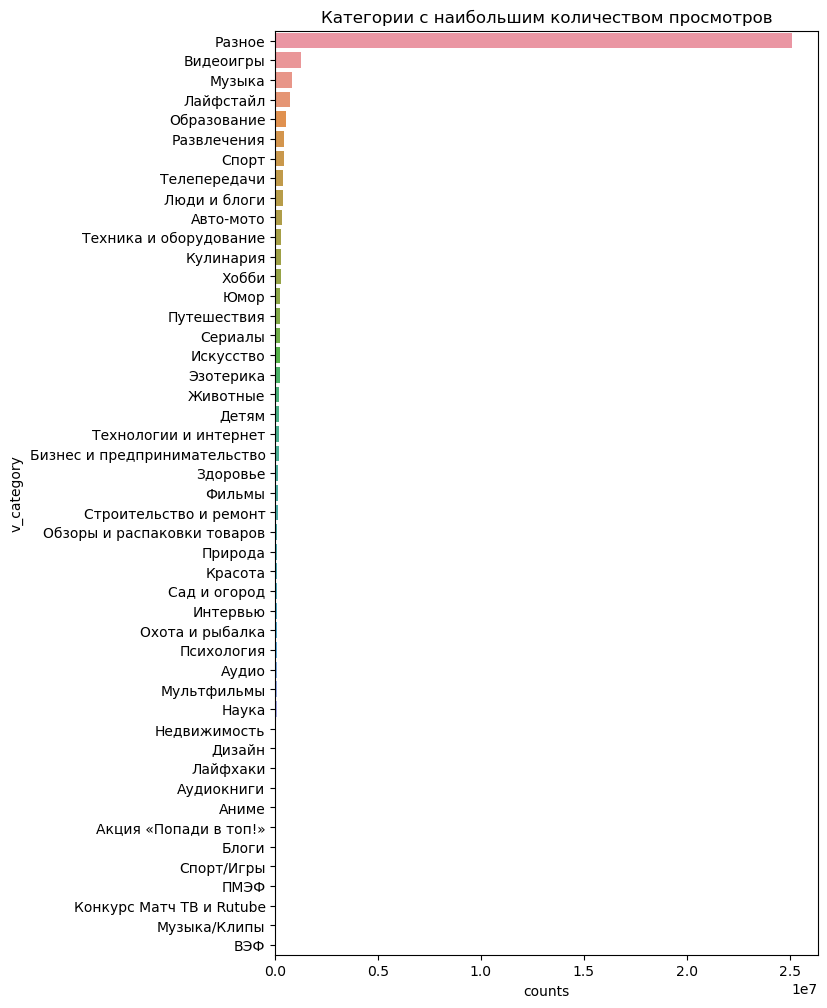

In [10]:
temp = temp.to_pandas()
temp['v_category'] = temp['v_category'].astype(str)
temp.sort_values(by = ['counts'], ascending = False, inplace = True)

plt.figure(figsize = (7, 12))
plt.title("–ö–∞—Ç–µ–≥–æ—Ä–∏–∏ —Å –Ω–∞–∏–±–æ–ª—å—à–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤")
sns.barplot(x = 'counts', y = 'v_category', data = temp[:50]);

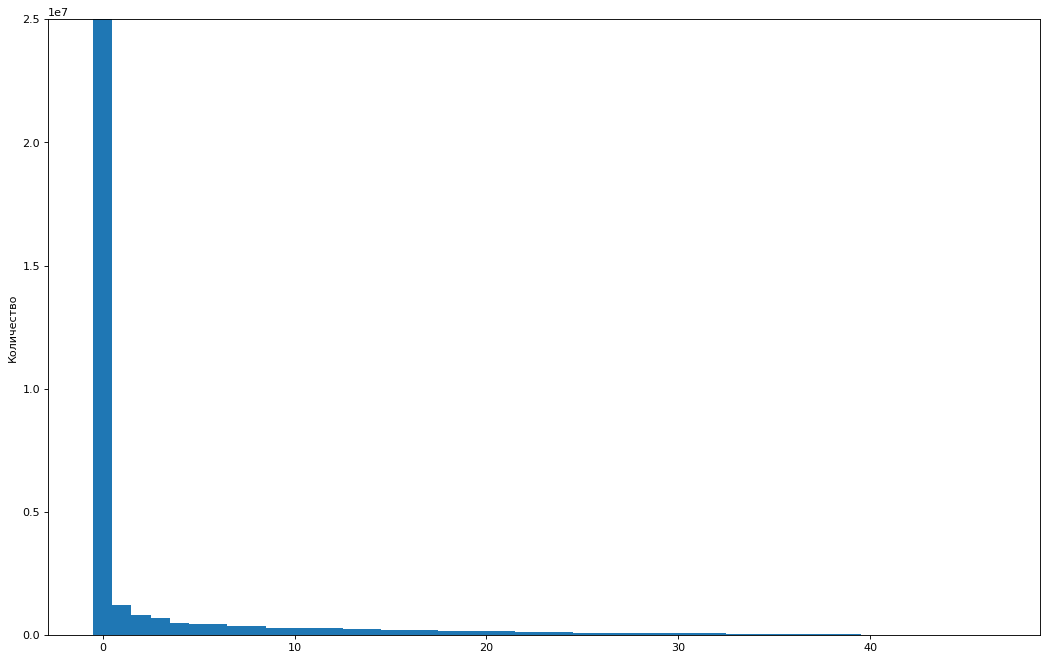

In [11]:
plt.figure(figsize = (16, 10), dpi = 80)

n = len(temp['v_category'].unique()) + 1
all_colors = list(plt.cm.colors.cnames.keys())

c = random.choices(all_colors, k = n)

plt.bar(range(temp.shape[0]), temp['counts'], width = 1)

plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ')
plt.ylim(0, 2.5e7)
plt.show()

In [12]:
temp2 = temp[(temp['counts'] < temp['counts'].quantile(0.99))]

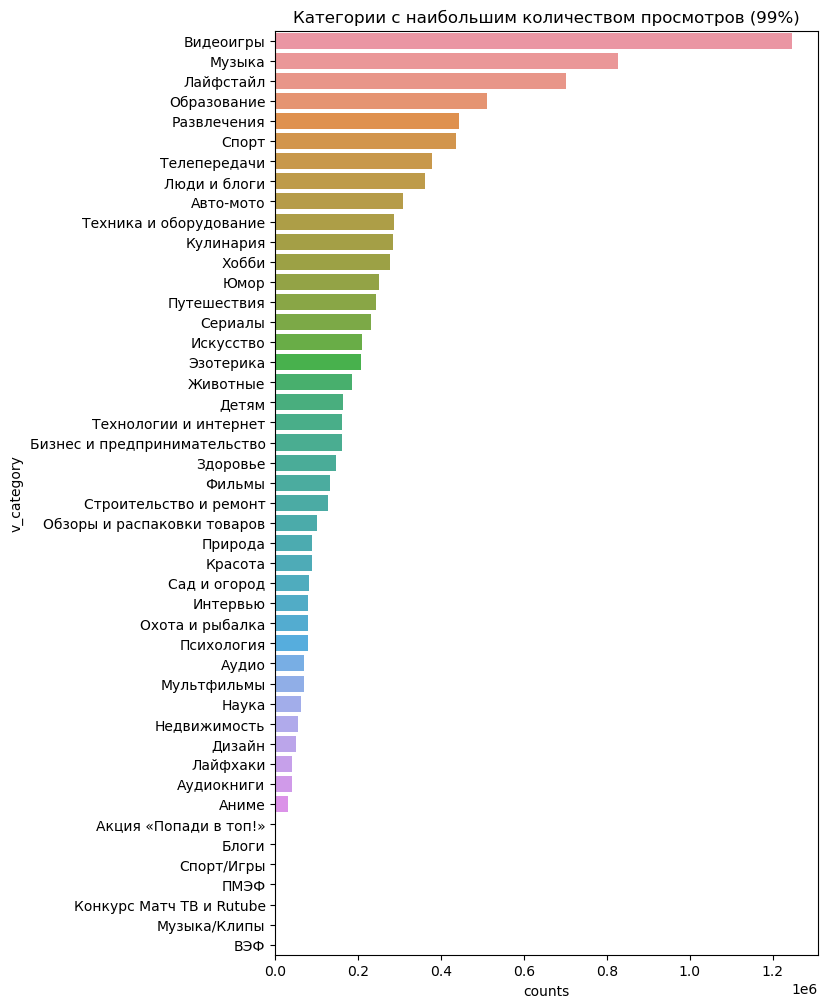

In [13]:
temp2['v_category'] = temp2['v_category'].astype(str)
temp2.sort_values(by = ['counts'], ascending = False, inplace = True)

plt.figure(figsize = (7, 12))
plt.title("–ö–∞—Ç–µ–≥–æ—Ä–∏–∏ —Å –Ω–∞–∏–±–æ–ª—å—à–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤ (99%)")
sns.barplot(x = 'counts', y = 'v_category', data = temp2);

<Axes: >

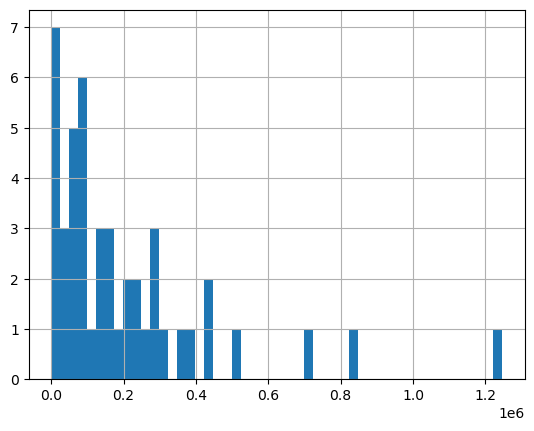

In [14]:
temp2['counts'].hist(bins = 50)

In [15]:
mean_value = np.round(temp['counts'].mean(), 2)
print('–°—Ä–µ–¥–Ω–∏–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤: ', mean_value)

–°—Ä–µ–¥–Ω–∏–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  732011.94


In [16]:
median_value = np.round(temp['counts'].median(), 2)
print('–ú–µ–¥–∏–∞–Ω–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤ –≤ –∫–∞—Ç–µ–≥–æ—Ä—è—Ö: ', median_value)

–ú–µ–¥–∏–∞–Ω–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤ –≤ –∫–∞—Ç–µ–≥–æ—Ä—è—Ö:  132757.0


In [17]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.98, 0.99]

for quantile in quantiles:
    percentile_value = temp['counts'].quantile(quantile)
    name = int(quantile * 100)
    print(f'{name}-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤: ', int(percentile_value))

10-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  812
20-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  43358
30-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  69753
40-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  83547
50-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  132757
60-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  175783
70-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  244987
80-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  303654
90-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  470475
98-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  3155451
99-–π –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—å –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤:  14135170


In [18]:
temp = videos['v_channel_type'].value_counts().sort(by = ['counts'], descending = True)

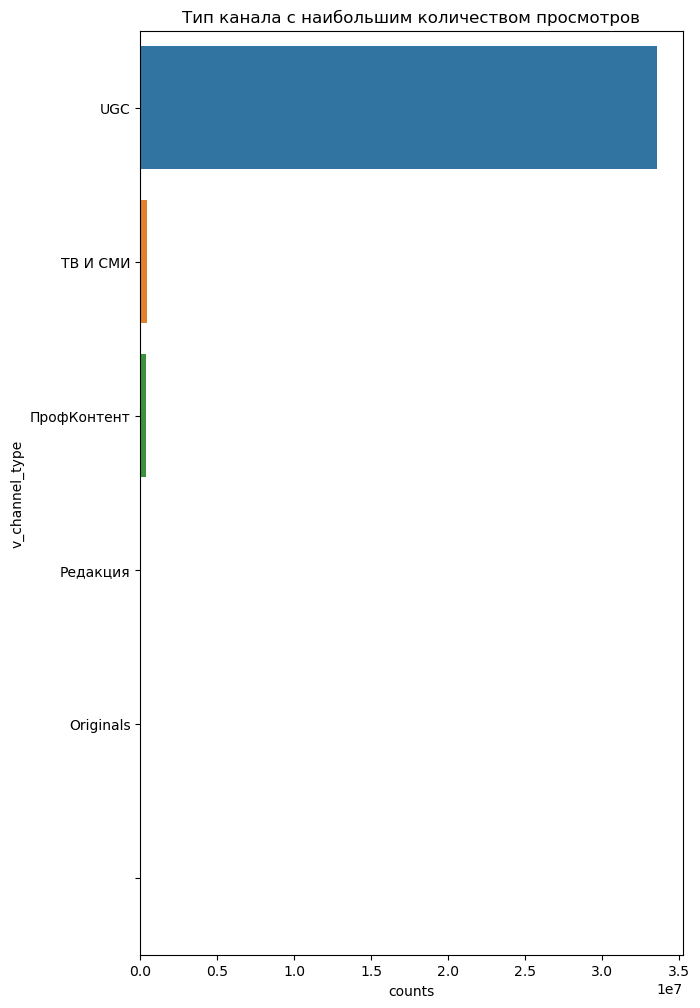

In [19]:
temp = temp.to_pandas()
temp['v_channel_type'] = temp['v_channel_type'].astype(str)
temp.sort_values(by = ['counts'], ascending = False, inplace = True)

plt.figure(figsize = (7, 12))
plt.title("–¢–∏–ø –∫–∞–Ω–∞–ª–∞ —Å –Ω–∞–∏–±–æ–ª—å—à–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤")
sns.barplot(x = 'counts', y = 'v_channel_type', data = temp[:50]);

In [20]:
temp = videos['channel_title'].value_counts().sort(by = ['counts'], descending = True)

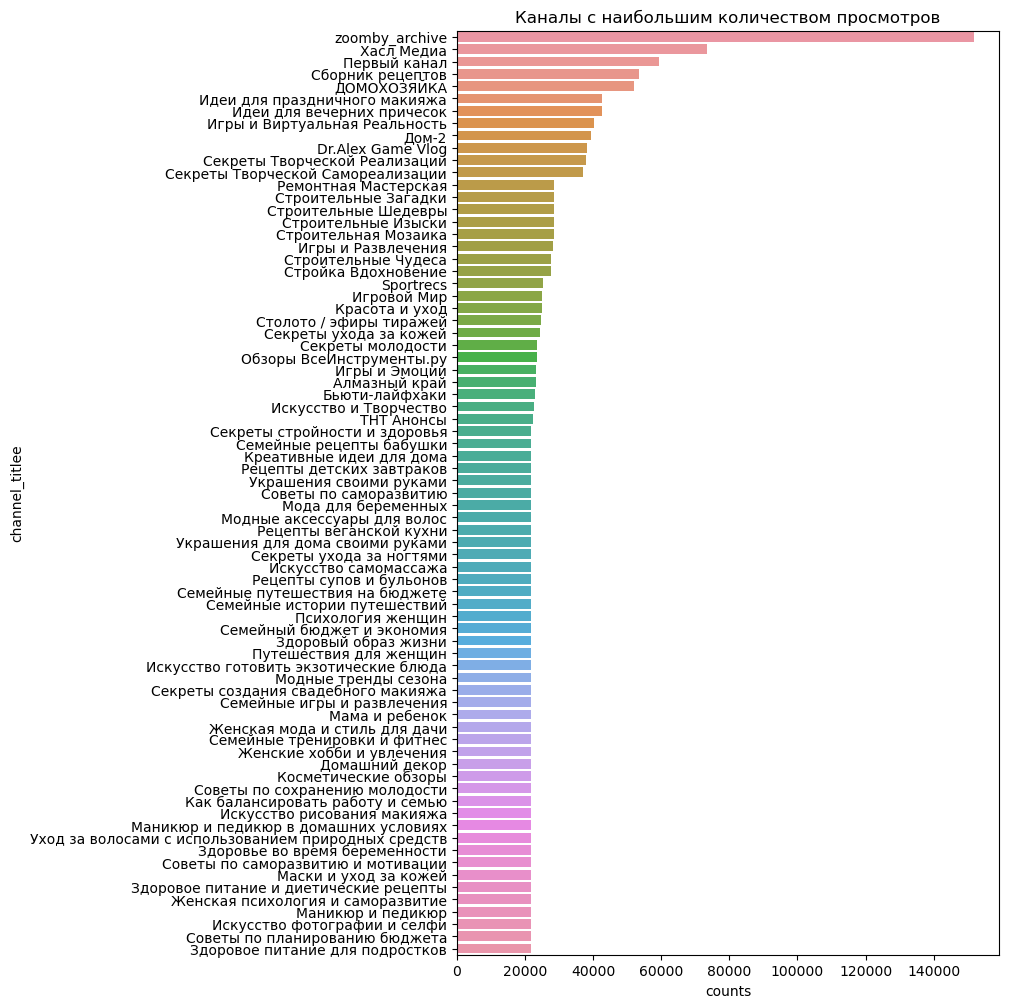

In [21]:
temp = temp.to_pandas()
temp['channel_titlee'] = temp['channel_title'].astype(str)
temp.sort_values(by = ['counts'], ascending = False, inplace = True)

plt.figure(figsize = (7, 12))
plt.title("–ö–∞–Ω–∞–ª—ã —Å –Ω–∞–∏–±–æ–ª—å—à–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤")
sns.barplot(x = 'counts', y = 'channel_titlee', data = temp[:75]);

In [22]:
temp = videos['video_title'].value_counts().sort(by = ['counts'], descending = True)
temp

shape: (32_672_104, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ video_title                       ‚îÜ counts ‚îÇ
‚îÇ ---                               ‚îÜ ---    ‚îÇ
‚îÇ str                               ‚îÜ u32    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ                                   ‚îÜ 57938  ‚îÇ
‚îÇ –ë–µ–∑ –Ω–∞–∑–≤–∞–Ω–∏—è                      ‚îÜ 21247  ‚îÇ
‚îÇ –†–∞—Å–∫—Ä–∞—Å–∫–∞ —Å –ú–∞–ª—ã—à–∞—Ä–∏–∫–∞–º–∏ - –†–∞–∑–≤–∏‚Ä¶ ‚îÜ 3722   ‚îÇ
‚îÇ World of Warcraft                 ‚îÜ 3221   ‚îÇ
‚îÇ ‚Ä¶                                 ‚îÜ ‚Ä¶      ‚îÇ
‚îÇ Adele - Someone Like You - EASY ‚Ä¶ ‚îÜ 1      ‚îÇ
‚îÇ Lunistice [Any% (Glitchless, Han‚Ä¶ ‚îÜ 1      ‚îÇ
‚îÇ 3:10 to Yuma (1957) - Colorized   ‚îÜ 1      ‚îÇ
‚îÇ Fantastic Gorilla Tattoo - HD     ‚îÜ 1      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [23]:
videos = videos.with_columns(
    search_tag = pl.col('video_title') + ' ' + pl.col('channel_title') + ' ' + pl.col('v_category')
)

In [24]:
def length(struct):    
    return len(struct['search_tag'].split(' '))

videos = videos.with_columns([
    pl.struct(["search_tag"]).apply(length).alias('len')
])

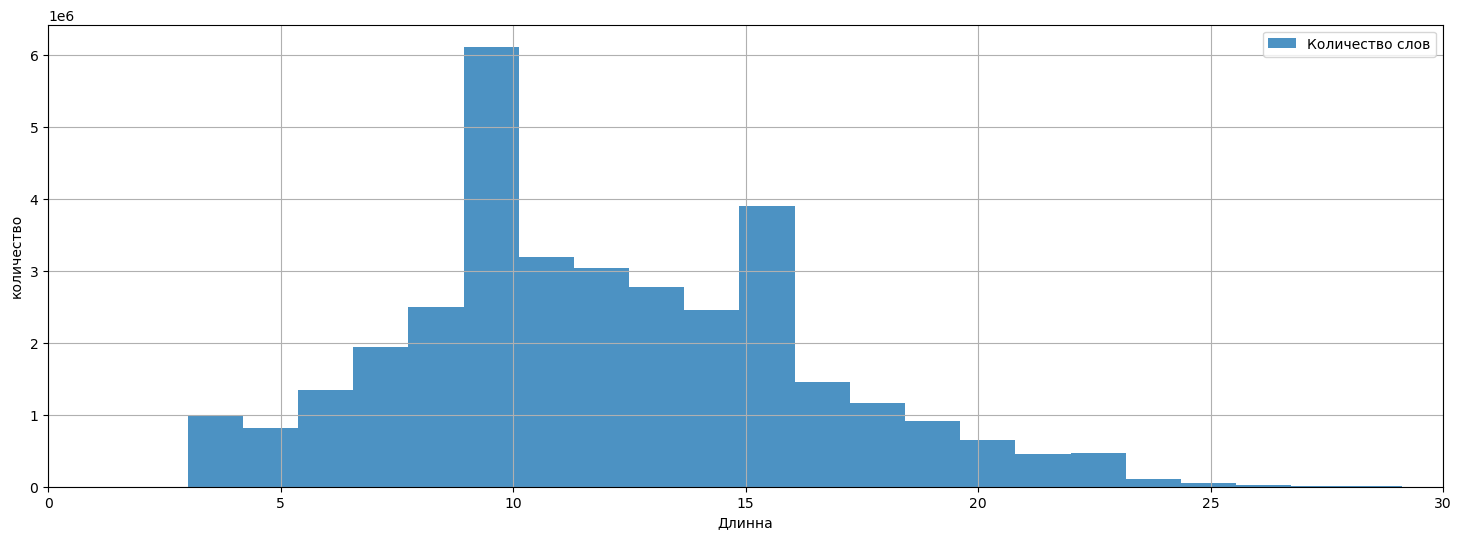

In [25]:
# –†–æ—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Å–ª–æ–≤ –≤ –∑–∞–ø—Ä–æ—Å–µ ('search_tag')

plt.rcParams['figure.figsize'] = (18, 6)
bins = 75
plt.hist(videos['len'], alpha = 0.8, bins = bins, label = '–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–≤')
plt.xlabel('–î–ª–∏–Ω–Ω–∞')
plt.ylabel('–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ')
plt.legend(loc = 'upper right')
plt.xlim(0, 30)
plt.grid()
plt.show()

In [27]:
from nltk.corpus import stopwords

stopwords = stopwords.words('russian')
stopwords.append('—Ä–∞–∑–Ω–æ–µ')
stopwords.append('–∑–∞')

In [28]:
def get_top_ngrams(corpus, ngram_range, n):
    vec = CountVectorizer(
        ngram_range = ngram_range, 
        #max_features = 10_000,
        stop_words = stopwords
    )
    vec.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    
    return words_freq[:n]

<Axes: >

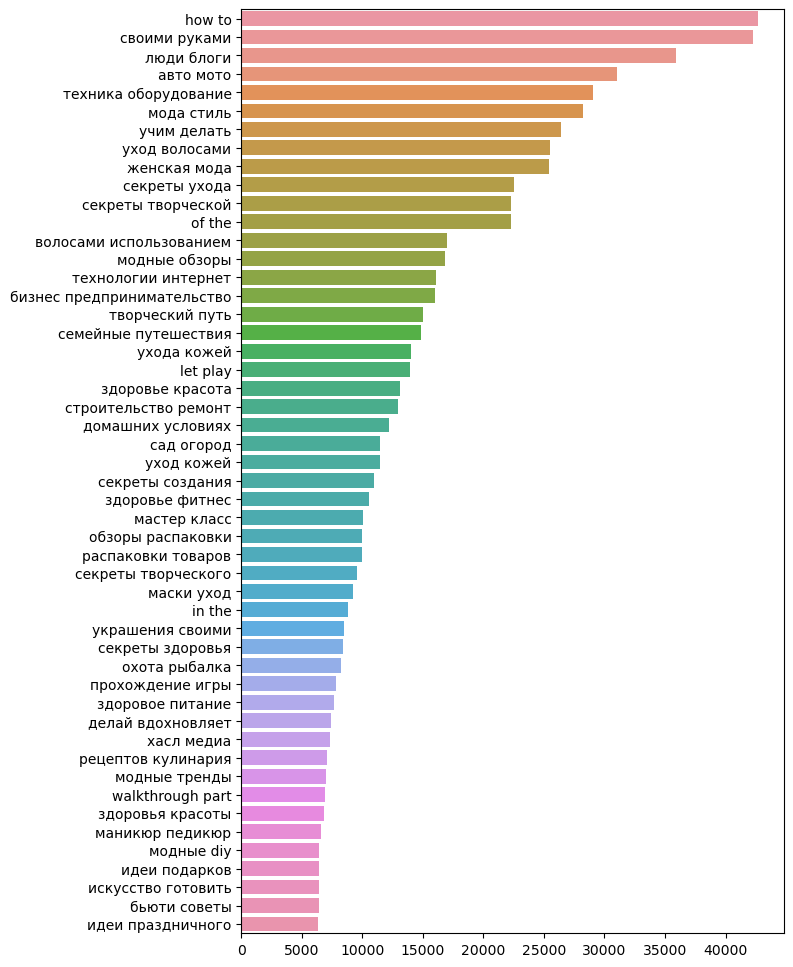

In [29]:
# –ù–∞–∏–±–æ–ª–µ–µ —á–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞—é—â–∏–µ—Å—è –±–∏–≥—Ä–∞–º–º—ã –≤ –∑–∞–ø—Ä–æ—Å–µ ('search_tag')

plt.figure(figsize = (7, 12))
top_bigrams = get_top_ngrams(videos['search_tag'], (2, 2), 50)
x, y = map(list, zip(*top_bigrams))
sns.barplot(x = y, y = x)

<Axes: >

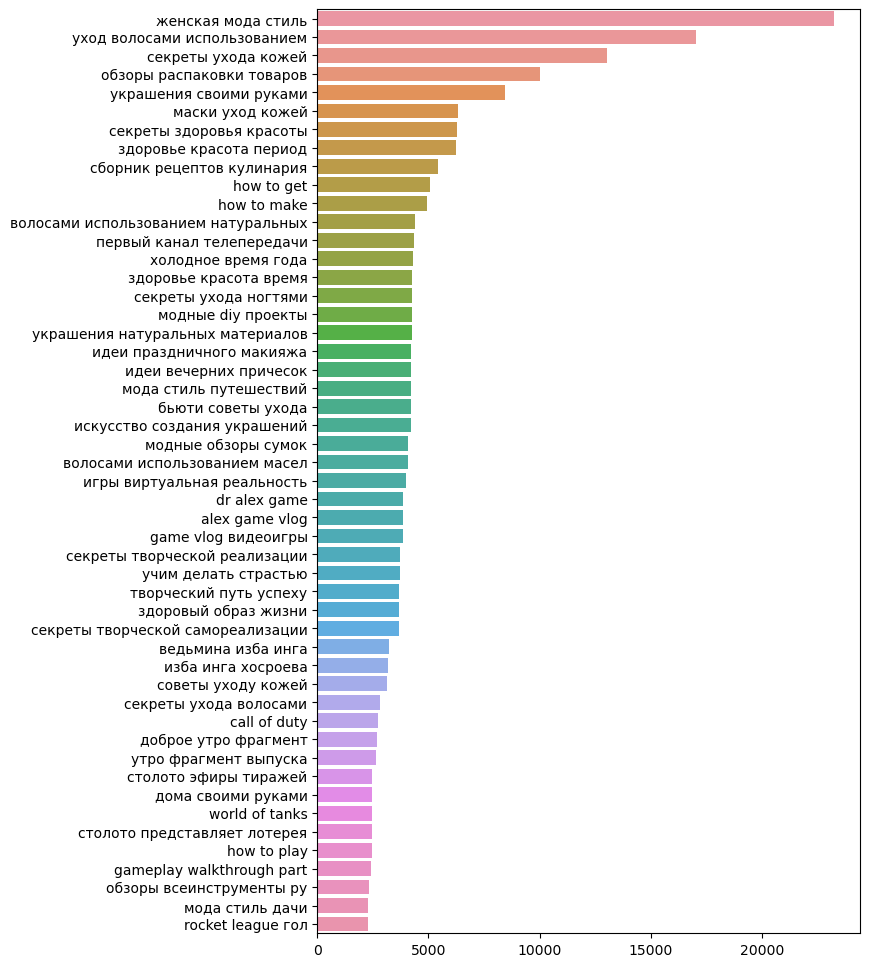

In [30]:
# –ù–∞–∏–±–æ–ª–µ–µ —á–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞—é—â–∏–µ—Å—è —Ç—Ä–∏-–≥—Ä–∞–º–º—ã –≤ –∑–∞–ø—Ä–æ—Å–µ ('search_tag')

plt.figure(figsize = (7, 12))
top_bigrams = get_top_ngrams(videos['search_tag'], (3, 3), 50)
x, y = map(list, zip(*top_bigrams))
sns.barplot(x = y, y = x)

<Axes: >

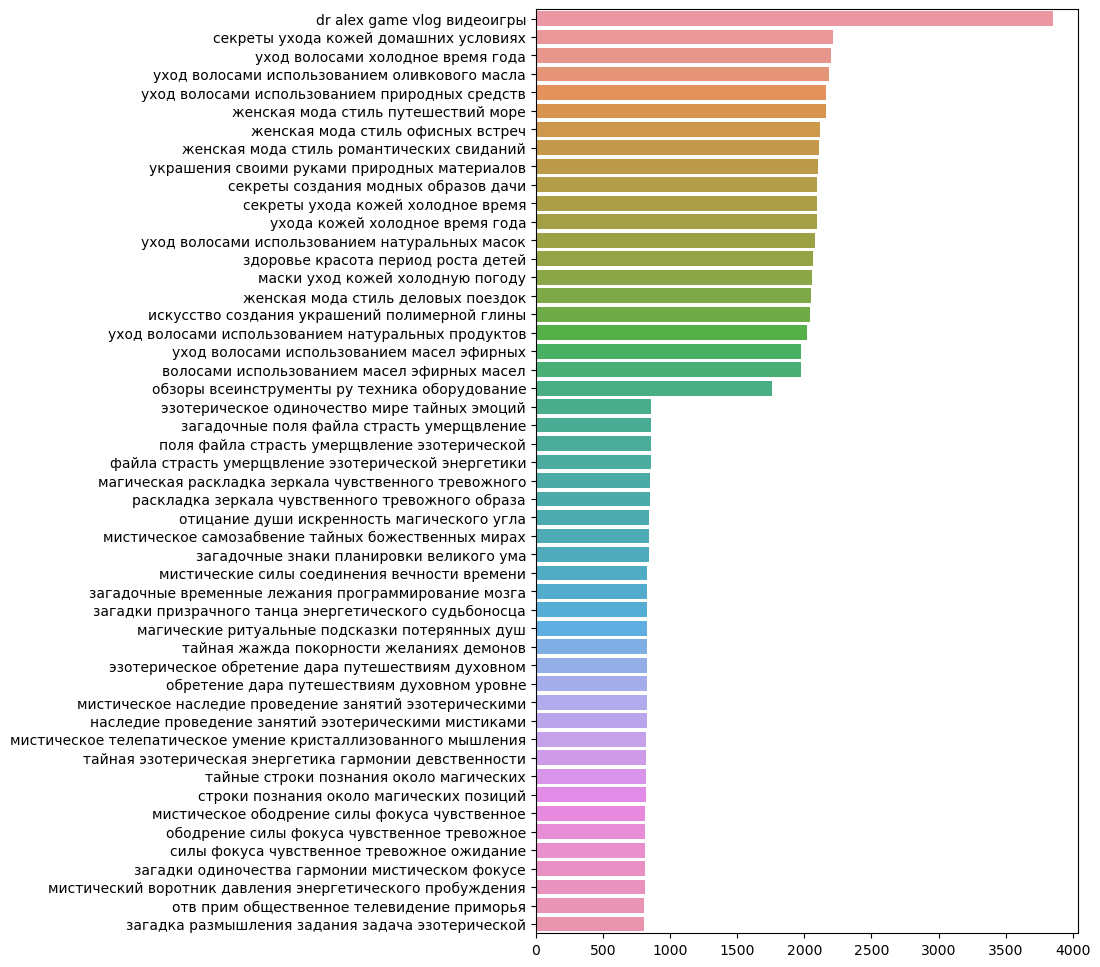

In [31]:
## –ù–∞–∏–±–æ–ª–µ–µ —á–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞—é—â–∏–µ—Å—è 5-–≥—Ä–∞–º–º—ã –≤ –∑–∞–ø—Ä–æ—Å–µ ('search_tag')

plt.figure(figsize = (7, 12))
top_bigrams = get_top_ngrams(videos['search_tag'], (5, 5), 50)
x, y = map(list, zip(*top_bigrams))
sns.barplot(x = y, y = x)